###Experiment: Single Objective Variance of True Probablity

####Aim
The objective of the **individual** is to simply increase variance added per row to the **population's** true_probablity per row.

####How does it make sure the accuracy is also increasing?
If the true_p per row is not greater than a threshold say 0.6, then the variance added for that row is zero. This makes sure that bad performing individuals are punished.

####Critism
Does nothing  directly to promote individuals which would help increase the population true_mean_probablity for rows at which it currently does bad. 




In [484]:
from collections import Counter
def predict_holdout(pop):
    forest_predictions = []
    subsample_sizes = []
    for ind_num, individual in enumerate(pop):
        func = toolbox.compile(expr=individual)
    #     print individual
        subsample = np.array([func(*record) for record in X_train])
        subsample_sizes.append(subsample.sum())

        if X_train[subsample].shape[0] == 0:
            continue

        clf = DecisionTreeClassifier(random_state=34092, max_depth=32)
        clf.fit(X_train[subsample], y_train[subsample])
        predictions = clf.predict(X_test_tot)
        forest_predictions.append(predictions)
    y_pred = np.array(
    [Counter(instance_forest_predictions).most_common(1)[0][0] for instance_forest_predictions in zip(*forest_predictions)])
    
    return np.sum(y_test_tot == y_pred)*1.0 / len(y_test_tot)

In [145]:
import operator
import itertools
import numpy as np

from deap import algorithms
from deap import base
from deap import creator
from deap import tools
from deap import gp

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.datasets import load_digits
from sklearn.cross_validation import train_test_split

np.seterr(all='raise')

digits = load_digits()
digit_features, digit_labels = digits.data, digits.target


X_train_tot, X_test_tot, y_train_tot, y_test_tot = train_test_split(digit_features, digit_labels, stratify=digit_labels,
                                                    train_size=0.75, test_size=0.25)


X_train, X_test, y_train, y_test = train_test_split(X_train_tot, y_train_tot, stratify=y_train_tot,
                                                    train_size=0.75, test_size=0.25)




# defined a new primitive set for strongly typed GP
pset = gp.PrimitiveSetTyped('MAIN', itertools.repeat(float, digit_features.shape[1]), bool, 'Feature')

# boolean operators
pset.addPrimitive(operator.and_, [bool, bool], bool)
pset.addPrimitive(operator.or_, [bool, bool], bool)
pset.addPrimitive(operator.not_, [bool], bool)

# floating point operators
# Define a protected division function
def protectedDiv(left, right):
    try: return left / right
    except (ZeroDivisionError, FloatingPointError): return 1.

pset.addPrimitive(operator.add, [float, float], float)
pset.addPrimitive(operator.sub, [float, float], float)
pset.addPrimitive(operator.mul, [float, float], float)
pset.addPrimitive(protectedDiv, [float, float], float)

# logic operators
# Define a new if-then-else function
def if_then_else(in1, output1, output2):
    if in1: return output1
    else: return output2

pset.addPrimitive(operator.lt, [float, float], bool)
pset.addPrimitive(operator.eq, [float, float], bool)
pset.addPrimitive(if_then_else, [bool, float, float], float)

# terminals
pset.addTerminal(False, bool)
pset.addTerminal(True, bool)
for val in np.arange(-10., 11.):
    pset.addTerminal(val, float)

creator.create('FitnessMax', base.Fitness, weights=(1.0,))
creator.create('Individual', gp.PrimitiveTree, fitness=creator.FitnessMax)

toolbox = base.Toolbox()
toolbox.register('expr', gp.genHalfAndHalf, pset=pset, min_=1, max_=3)
toolbox.register('individual', tools.initIterate, creator.Individual, toolbox.expr)
toolbox.register('population', tools.initRepeat, list, toolbox.individual)
toolbox.register('compile', gp.compile, pset=pset)



row_prob = {} # Each key is row index,
row_mean_prob = {}
def update_true_class_variance(pop_):
    
    """
    pop is a list of indiv.
    Each indiv
    """
    global row_prob, row_mean_prob
    row_prob = {} #reset
    row_mean_prob = {}
    
    for individual in pop_:
        func = toolbox.compile(expr=individual)
        subsample = np.array([func(*record) for record in X_train])

        if X_train[subsample].shape[0] == 0:
            continue

        clf = DecisionTreeClassifier(random_state=34092, max_depth=32)
        clf.fit(X_train[subsample], y_train[subsample])

        probas = clf.predict_proba(X_test)
#         print clf.classes_
        for ix, row in enumerate(probas):
#             print row
            try:
                true_p = row[y_test[ix]]
            except:
                true_p = np.nan
            try:
                row_prob[ix].append(true_p)
            except:
                row_prob[ix] = [true_p]
#                 print row_prob[ix]
    
#     print 'row_prob', row_prob
    for key in row_prob.keys():
        row_mean_prob[key] = np.nanmean(row_prob[key])
    
    return    
    

def evaluate_individual(individual):
    global row_mean_prob
    # Transform the tree expression into a callable function
    func = toolbox.compile(expr=individual)
    subsample = np.array([func(*record) for record in X_train])
    
    if X_train[subsample].shape[0] == 0:
        return 1e-20,
    
    clf = DecisionTreeClassifier(random_state=34092, max_depth=32)
    clf.fit(X_train[subsample], y_train[subsample])
    score = clf.score(X_test, y_test)
    
    
    
    probas = clf.predict_proba(X_test)
    total_variance = []
    for ix, row in enumerate(probas):
        try:
            true_p = row[y_test[ix]]
        except:
            true_p = 0
        mean_p = row_mean_prob[ix]
        
        # Can also simply do - 1 - true_p and measure variance in the model.
        if true_p>=0.75:
            added_variance = (mean_p - true_p)**2
        elif true_p>mean_p: #Giving more score to individuals helping with low mean true_p
            added_variance = (mean_p-true_p)**2
        else:
            added_variance = 0 #Should this be nan?
        total_variance.append(added_variance)
    
    mean_variance_added = np.sqrt(np.nanmean(total_variance))
    
    return mean_variance_added,
    
toolbox.register('evaluate', evaluate_individual)
#todo: change this according to multi-objective
toolbox.register('select', tools.selTournament, tournsize=3)
# toolbox.register('select', tools.selNSGA2)

toolbox.register('mate', gp.cxOnePoint)
toolbox.register('expr_mut', gp.genFull, min_=0, max_=3)
toolbox.register('mutate', gp.mutUniform, expr=toolbox.expr_mut, pset=pset)

population = toolbox.population(n=100)
halloffame = tools.HallOfFame(1)
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register('std', np.std)
stats.register('min', np.min)
stats.register('avg', np.mean)
stats.register('max', np.max)

clf = DecisionTreeClassifier(random_state=34092)
clf.fit(X_train_tot, y_train_tot)
print('Base DecisionTreeClassifier accuracy: {}'.format(clf.score(X_test_tot, y_test_tot)))

clf = RandomForestClassifier(random_state=34092, n_estimators=100)
clf.fit(X_train_tot, y_train_tot)
print('Base RandomForestClassifier accuracy: {}'.format(clf.score(X_test_tot, y_test_tot)))

clf = GradientBoostingClassifier(random_state=34092)
clf.fit(X_train_tot, y_train_tot)
print('Base GradientBoostingClassifier accuracy: {}'.format(clf.score(X_test_tot, y_test_tot)))

print('')

cxpb = 0.5
mutpb = 0.5
ngen = 300
verbose = True
holdout_perf = {}

logbook = tools.Logbook()
logbook.header = ['gen', 'nevals'] + (stats.fields if stats else [])


update_true_class_variance(population)

# Evaluate the individuals with an invalid fitness ~
# invalid_ind = [ind for ind in population if not ind.fitness.valid]
invalid_ind = [ind for ind in population]
fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
for ind, fit in zip(invalid_ind, fitnesses):
    ind.fitness.values = fit

if halloffame is not None:
    halloffame.update(population)

record = stats.compile(population) if stats else {}
logbook.record(gen=0, nevals=len(invalid_ind), **record)
if verbose:
    print(logbook.stream)

# Begin the generational process
for gen in range(1, ngen + 1):
    # Select the next generation individuals
    offspring = toolbox.select(population, len(population))

    # Vary the pool of individuals
    offspring = algorithms.varAnd(offspring, toolbox, cxpb, mutpb)

    # Evaluate the individuals with an invalid fitness
    #invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
    invalid_ind = [ind for ind in offspring]
    fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit

    # Update the hall of fame with the generated individuals
    if halloffame is not None:
        halloffame.update(offspring)

    # Replace the current population by the offspring
    population[:] = offspring

    #Generate true class predict_proba variance for each row.
    update_true_class_variance(population)
    
    # Append the current generation statistics to the logbook
#     fits = pd.DataFrame()
#     fits['score'] = map(lambda x: x.fitness.values[0], population)
#     fits['contrib_variance'] = map(lambda x: x.fitness.values[1], population)
    
    record = stats.compile(population) if stats else {}
    logbook.record(gen=gen, nevals=len(invalid_ind),**record)
    holdout_perf[gen] = predict_holdout(population)
    if verbose:
        print(logbook.stream)
#         print(fits.score.mean())
#         print(fits.contrib_variance.mean())
        print 'Performance on hold-out set:', holdout_perf[gen]
str(halloffame[0])

Base DecisionTreeClassifier accuracy: 0.853658536585
Base RandomForestClassifier accuracy: 0.966740576497
Base GradientBoostingClassifier accuracy: 0.964523281596

gen	nevals	std     	min  	avg     	max     
0  	100   	0.101489	1e-20	0.121423	0.305356
1  	100   	0.0982685	1e-20	0.158584	0.326473
Performance on hold-out set: 0.831485587583
2  	100   	0.0863841	1e-20	0.157197	0.297109
Performance on hold-out set: 0.855875831486
3  	100   	0.0917441	1e-20	0.182348	0.307357
Performance on hold-out set: 0.90465631929
4  	100   	0.0754628	1e-20	0.267183	0.327829
Performance on hold-out set: 0.942350332594
5  	100   	0.0725832	1e-20	0.210129	0.273051
Performance on hold-out set: 0.935698447894
6  	100   	0.0629318	1e-20	0.207019	0.265248
Performance on hold-out set: 0.937915742794
7  	100   	0.0326421	1e-20	0.208612	0.242449
Performance on hold-out set: 0.942350332594
8  	100   	0.0445024	1e-20	0.192872	0.232356
Performance on hold-out set: 0.935698447894
9  	100   	0.0222715	0.0805425	0.2227

'lt(if_then_else(or_(True, False), protectedDiv(Feature22, Feature47), mul(Feature11, Feature48)), if_then_else(True, Feature52, Feature36))'

(array([   6.,    4.,    7.,   17.,   14.,   21.,   25.,   36.,   53.,  154.]),
 array([ 0.14141414,  0.22727273,  0.31313131,  0.3989899 ,  0.48484848,
         0.57070707,  0.65656566,  0.74242424,  0.82828283,  0.91414141,  1.        ]),
 <a list of 10 Patch objects>)

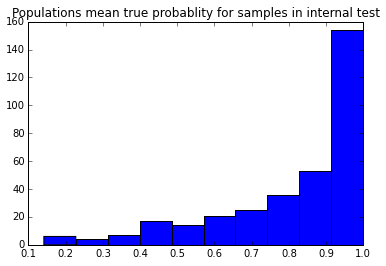

In [146]:
plt.title('Populations mean true probablity for samples in internal test')
plt.hist(row_mean_prob.values())
## row_mean_prob is the dictionary which holds per row true_p_variance.

Observation: Ideally, the graph should be as right skewed as possible. 


In [120]:
print "HOF Performance individually: ", predict_holdout([halloffame[0]])
pop = offspring[:]
# pop = [halloffame[0]]


HOF Performance individually:  0.818181818182


-------
Some statistics on the final population


In [121]:
forest_predictions = []
subsample_sizes = []
for ind_num, individual in enumerate(pop):
    func = toolbox.compile(expr=individual)
#     print individual
    subsample = np.array([func(*record) for record in X_train])
    subsample_sizes.append(subsample.sum())
    
    if X_train[subsample].shape[0] == 0:
        continue
    
    clf = DecisionTreeClassifier(random_state=34092)
    clf.fit(X_train[subsample], y_train[subsample])
    predictions = clf.predict(X_test_tot)
    forest_predictions.append(predictions)

In [122]:
from sklearn.metrics import accuracy_score

y_pred = np.array(
    [Counter(instance_forest_predictions).most_common(1)[0][0] for instance_forest_predictions in zip(*forest_predictions)])
np.sum(y_test_tot == y_pred)*1.0 / len(y_test_tot)

0.94013303769401335

In [123]:
# for x in 
import pandas as pd
fits = pd.DataFrame()
# fits['score'] = map(lambda x: x.fitness.values[0], pop)
fits['contrib_variance'] = map(lambda x: x.fitness.values[0], pop)

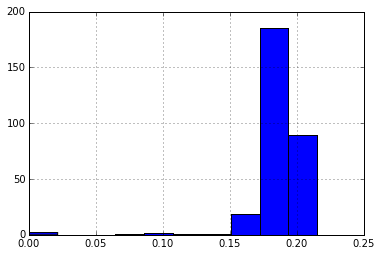

In [124]:
%matplotlib inline
import matplotlib.pyplot as plt
fits.contrib_variance.hist()

1009
760.226666667
139.377551835


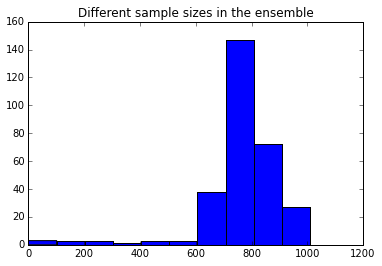

In [125]:
plt.title('Different sample sizes in the ensemble')
plt.hist(subsample_sizes)
print X_train.shape[0]
print np.mean(subsample_sizes)
print np.std(subsample_sizes)


In [126]:

import pandas as pd
print "Mean # of unique labels predicted per sample by the ensemble.", pd.DataFrame(forest_predictions).apply(
    lambda x: len(x.unique()), axis=0).mean()

Mean # of unique labels predicted per sample by the ensemble. 6.69623059867


----

~ ~ ~ end of notebook - rough work follows ~ ~ ~

----

In [475]:
pd.DataFrame(forest_predictions)

,0,1,2,3,4,5,6,7,8,9,...,441,442,443,444,445,446,447,448,449,450
0,6,6,1,0,1,8,2,2,7,4,...,8,8,0,5,2,2,9,9,3,4
1,6,6,1,0,1,8,2,2,7,4,...,8,8,0,5,2,2,9,9,3,4
2,6,6,1,0,1,8,2,2,7,4,...,8,8,0,5,2,2,9,9,3,4
3,6,6,1,0,1,8,2,2,7,4,...,8,8,8,5,2,2,9,9,3,4
4,6,6,1,0,1,8,2,2,7,4,...,8,8,0,5,2,2,9,9,3,4
5,6,6,1,0,1,8,2,2,7,4,...,8,8,0,5,2,2,9,9,3,1
6,6,6,1,0,1,8,2,2,7,4,...,8,8,0,5,2,2,9,9,3,4
7,6,6,1,0,1,8,2,2,7,4,...,8,8,0,5,2,2,9,9,3,4
8,6,6,1,0,1,8,2,2,7,4,...,8,8,0,5,2,2,9,9,3,4
9,6,6,1,0,1,8,2,2,7,4,...,8,8,0,5,2,2,9,9,3,1


In [97]:
from sklearn import __version__

In [98]:
__version__

'0.17.1'

In [113]:
RandomForestClassifier?

In [1]:
from sklearn.neighbors import KNeighborsClassifier


In [2]:
KNeighborsClassifier?